In [1]:
import httpx
from bs4 import BeautifulSoup
import csv
import random
import time
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from pyhive import hive 

# # 读取数据
# # 连接到Hive 
# conn = hive.Connection(host='192.168.147.30', port=9091, username='hiveuser', auth='LDAP', password='123456')
# # 执行查询 
# query = "SELECT * FROM weather_data" 
# df = pd.read_sql(query, conn) 
# # 关闭连接 
# conn.close()

# df.info()

df = pd.read_csv('近五年(2019-2024)茂名市天气记录数据.csv')

# 清洗掉错误数据
# 创建一个布尔掩码，用于判断每行是否包含“-”
mask = df.apply(lambda row: row.astype(str).str.contains('-').any(), axis=1)
# 根据布尔掩码删除包含“-”的行
df = df[~mask]
# 再次检查并删除可能遗漏的包含“-”的行（可根据实际情况确定是否需要重复这步）
mask = df.apply(lambda row: row.astype(str).str.contains('-').any(), axis=1)
df = df[~mask]

#英文转为中文接收
# df["日期"] = df["weather_data.record_date"]
# df["最高温"] = df["weather_data.max_temp"]
# df["最低温"] = df["weather_data.min_temp"]
# df["天气"] = df["weather_data.weather"]
# df["风向"] = df["weather_data.wind_direction"]
# df["风力"] = df["weather_data.wind_direction"]
# df["空气质量指数"] = df["weather_data.air_quality_index"]
# df["空气质量指数标签"] = df["weather_data.air_quality_label"]


# 转换为可以由numpy简单处理的格式
df["日期"] = pd.to_datetime(df["日期"], format="%Y/%m/%d")
df["年份"] = df["日期"].dt.year
df["月份"] = df["日期"].dt.month
df["日"] = df["日期"].dt.day
df = df.drop("日期", axis=1)

# 将object格式转为浮点数
df["最高温"] = df["最高温"].astype(str)
df["最低温"] = df["最低温"].astype(str)
df["最高温"] = df["最高温"].str.replace("°", "").astype(float)
df["最低温"] = df["最低温"].str.replace("°", "").astype(float)

# 处理风向
wind_direction_mapping = {"东风": 0, "南风": 1, "西风": 2, "北风": 3, "东南风": 4, "西南风": 5, "西北风": 6, "东北风": 7}
df["风向"] = df["风向"].map(wind_direction_mapping)

# 处理风力
# 先将风力列转换为字符串类型（确保后续替换操作能正常进行）
df["风力"] = df["风力"].astype(str)
# 使用replace方法将"微风"替换为"0级风"，可根据实际增加更多替换
df["风力"] = df["风力"].replace("微风", "0级风")
# 再提取数字部分并转换为整数类型
df["风力"] = df["风力"].str.extract('(\d+)').astype(int)

# 处理空气质量指数
df["空气质量指数"] = df["空气质量指数"].astype(float)

# 处理空气质量指数标签（此部分若对温度预测帮助不大，可考虑后续是否保留）
Air_Quality_Index_label = {"优": 2, "良": 1, "轻度": 0}
df["空气质量指数标签"] = df["空气质量指数标签"].map(Air_Quality_Index_label)

# 优化天气特征处理 - 新增是否有降水列
def has_precipitation(weather_type):
    precipitation_keywords = ["雨", "雪", "雹", "雾"]
    for keyword in precipitation_keywords:
        if keyword in weather_type:
            return 1
    return 0
df["是否有降水"] = df["天气"].apply(has_precipitation)

# 优化天气特征处理 - 新增云量等级列
def cloud_cover_level(weather_type):
    if "晴" in weather_type:
        return 0
    elif "多云" in weather_type:
        return 1
    elif "阴" in weather_type:
        return 2
    return 0
df["云量等级"] = df["天气"].apply(cloud_cover_level)

# 优化天气特征处理 - 新增天气变化列及编码
df["天气变化"] = df["天气"].shift(1)
df["天气变化"] = df.apply(lambda row: f"{row['天气变化']}->{row['天气']}" if pd.notnull(row['天气变化']) else row['天气'], axis=1)
weather_change_mapping = {}
unique_weather_changes = df["天气变化"].unique()
for index, change in enumerate(unique_weather_changes):
    weather_change_mapping[change] = index
df["天气变化编码"] = df["天气变化"].map(weather_change_mapping)

# 对天气进行编码（原代码方式，可根据后续情况决定是否保留或调整）
weather_types = ['多云~小雨', '小雨', '阴', '多云', '阴~多云', '阴~小雨', '多云~阴', '晴', '晴~多云', '阵雨~多云', '阵雨', '中雨',
                 '多云~阵雨', '雷阵雨~阵雨', '中雨~阵雨', '中雨~多云', '中雨~阴', '中雨~雷阵雨', '阵雨~中雨', '大到暴雨~中到大雨',
                 '阵雨~阴', '大雨~中雨', '阵雨~大雨', '大到暴雨', '大雨~阵雨', '雷阵雨~多云', '多云~雷阵雨', '大到暴雨~阵雨', '大雨',
                 '中雨~大雨', '大到暴雨~中雨', '雷阵雨~中雨', '雷阵雨', '大雨~大到暴雨', '多云~晴', '多云~中雨', '小雨~多云', '阴~晴',
                 '阴~中雨', '小雨~阴', '小雨~中雨', '阴~阵雨', '小雨~阵雨', '小雨~雷阵雨', '大雨~多云', '雾~多云', '阴~雷阵雨',
                 '小雨~大雨', '阴~大雨', '多云~大雨', '小雨~晴', '雾~阴', '中雨~小雨', '阴~暴雨', '大暴雨~大雨', '雾~晴', '小雨~暴雨',
                 '暴雨', '雾~阵雨', '雾~小雨', '雾~中雨', '雾~雷阵雨', '暴雨~中雨', '大雨~暴雨', '大雨~雷阵雨', '暴雨~阵雨',
                 '大暴雨~暴雨', '暴雨~大雨', '暴雨~晴', '大雨~阴', '暴雨~多云', '中雨~暴雨', '中雨~大暴雨', '大雨~小雨', '中雨~晴']
weather_mapping = {}
for index, weather_type in enumerate(weather_types):
    weather_mapping[weather_type] = index
df['天气编码'] = df['天气'].map(weather_mapping)
df = df.drop("天气", axis=1)

# 特征组合与交互项添加（风向和风力交互示例）
wind_direction = df[["风向"]].values
wind_force = df[["风力"]].values
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
wind_combined = poly.fit_transform(np.concatenate((wind_direction, wind_force), axis=1))
wind_combined_df = pd.DataFrame(wind_combined, columns=["风向", "风力", "风向_风力交互"])
df = pd.concat([df, wind_combined_df], axis=1)

# 清除包含空值的行
df = df.dropna()


# 将处理好的数据保存为csv文件，设置编码为utf-8，不保存索引列
df.to_csv('maoming_optimized.csv', encoding='utf-8', index=False)


平均温度        1.000000
最低温         0.964993
最高温         0.964063
空气质量指数      0.392142
空气质量指数标签    0.347292
月份          0.308138
风力          0.194739
年份          0.136731
风向          0.129845
是否有降水       0.092162
风力.1        0.058765
风向_风力交互     0.048701
天气编码        0.044301
日           0.031897
云量等级        0.025567
温差          0.025274
天气变化编码      0.014537
风向.1        0.004197
Name: 平均温度, dtype: float64


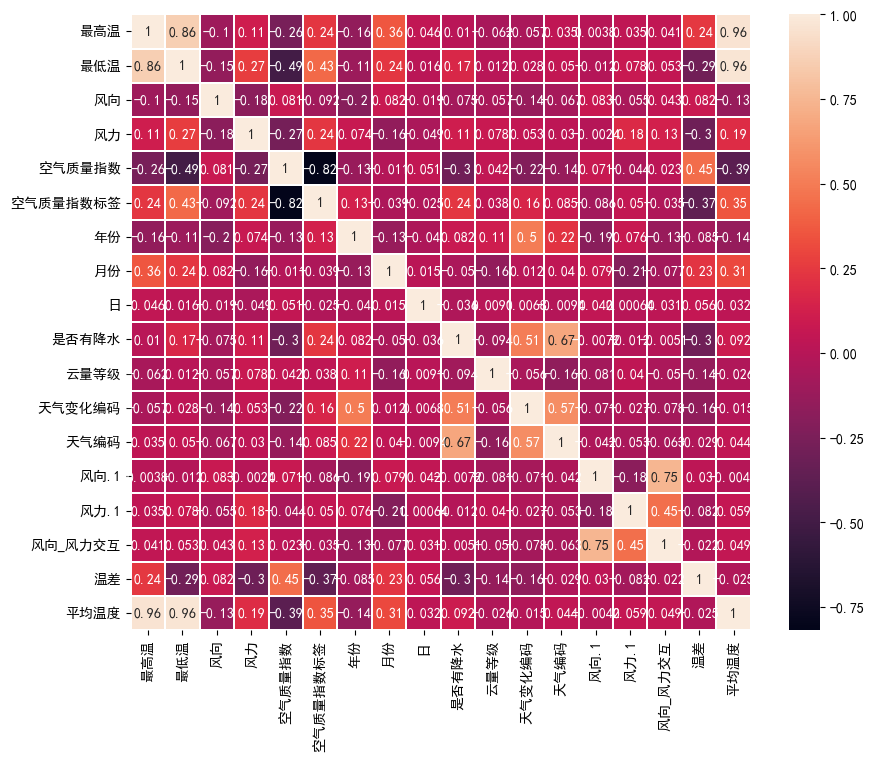

In [2]:
import httpx
from bs4 import BeautifulSoup
import csv
import random
import time
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
#df = pd.read_csv('maoming_optimized.csv',encoding='GBK')
df = pd.read_csv('maoming_optimized.csv')

# 新增特征示例（温差、平均温度，延续你提供代码的思路）
df['温差'] = df['最高温'] - df['最低温']
df['平均温度'] = (df["最高温"] + df["最低温"]) / 2

# 重新审视特征选择（以预测最高温为例，根据实际情况调整目标和特征列表）
target = "平均温度"
features = ["月份", "日", "是否有降水", "云量等级", "天气变化编码", "风向", "风力", "空气质量指数", "风向_风力交互", "温差"]

# 数据归一化处理（示例对部分特征归一化，可根据实际情况调整要归一化的特征列）
# cols_to_normalize = ["风力", "空气质量指数", "温差", "平均温度"]
# scaler = MinMaxScaler()
# df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

# 相关性分析部分（与你提供代码类似，但基于更新后的特征和数据）
df = df.drop("天气变化", axis=1)
corr_matrix = df.corr()
# 提取目标变量与其他变量的相关系数，并按绝对值大小排序
sorted_corr = corr_matrix[target].abs().sort_values(ascending=False)
print(sorted_corr)

# 设置中文字体显示及负号显示正常（适用于中文标注及可视化）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 绘制相关性热图（可视化各特征之间以及与目标变量的相关性）
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), linewidths=.2, annot=True)
plt.show()

In [3]:
# 后续可以添加模型训练、评估等代码，例如划分训练集和测试集，使用XGBoost模型训练并预测等，示例如下（可根据实际调整和完善）
# 划分训练集和测试集（假设80%数据用于训练，20%用于测试）
X = df[features]
y = df["平均温度"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 创建XGBoost模型对象（可调整参数优化模型性能）
# model = xgb.XGBRegressor()

from sklearn.model_selection import GridSearchCV

# 定义要搜索的参数网格
param_grid = {
   'max_depth': [3, 5, 7],
   'eta': [0.05, 0.1, 0.2],
   'subsample': [0.7, 0.8, 0.9],
   'colsample_bytree': [0.7, 0.8, 0.9]
}

# 创建XGBoost模型对象（先不传入具体参数）
model = xgb.XGBRegressor()

# 创建网格搜索对象，传入模型、参数网格和评估指标等
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# 在训练集上进行网格搜索，找到最优参数组合
grid_search.fit(X_train, y_train)

# 获取最优参数
best_params = grid_search.best_params_
print(best_params)

# 使用最优参数创建模型并训练
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)


# # 模型训练
# model.fit(X_train, y_train)
model = best_model
# 模型预测
y_pred = model.predict(X_test)


{'colsample_bytree': 0.9, 'eta': 0.1, 'max_depth': 5, 'subsample': 0.7}


In [4]:
# 评估模型预测结果（示例使用均方误差，可根据实际选用其他评估指标）
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# 1. 均方误差（MSE）
mse = mean_squared_error(y_test, y_pred)

# 2. 决定系数（R²）
r2 = r2_score(y_test, y_pred)

# 3. 平均绝对误差（MAE）
mae = mean_absolute_error(y_test, y_pred)

# 4. 均方根误差（RMSE），是MSE的平方根，对误差的衡量更符合直观感受
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


# 5. 平均绝对百分比误差（MAPE），衡量预测值相对误差的百分比，能直观体现相对误差情况，但要注意分母不能为0的情况
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_value = mape(y_test, y_pred)

print(f"均方误差（MSE）: {mse}")
print(f"决定系数（R²）: {r2}")
print(f"平均绝对误差（MAE）: {mae}")
print(f"均方根误差（RMSE）: {rmse}")
print(f"平均绝对百分比误差（MAPE）: {mape_value}")

均方误差（MSE）: 2.520730818347855
决定系数（R²）: 0.8959693866949018
平均绝对误差（MAE）: 1.1772193653892924
均方根误差（RMSE）: 1.5876809560953533
平均绝对百分比误差（MAPE）: 5.53700013274839


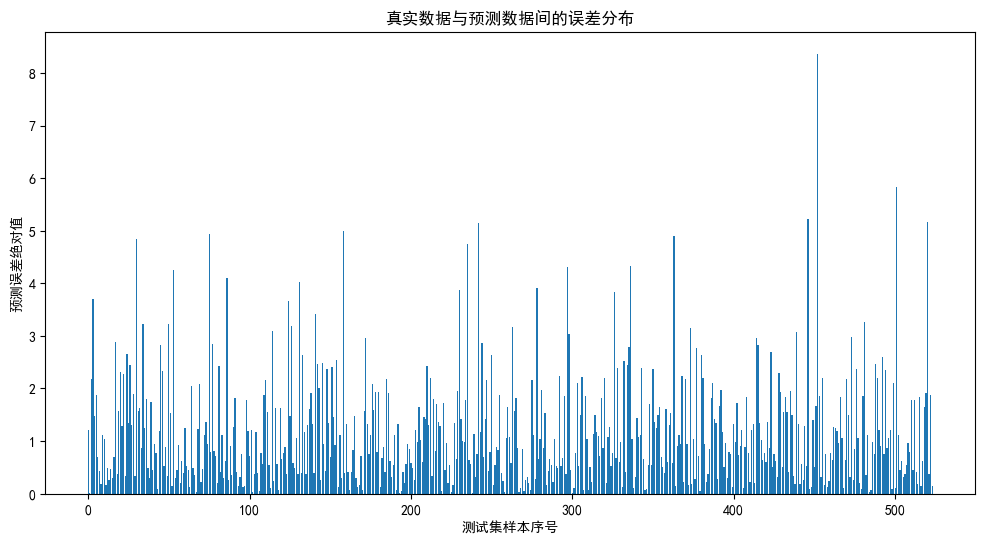

In [5]:
errors = abs(y_test - y_pred)
plt.figure(figsize=(12, 6))  # 设置图形大小
plt.bar(range(len(errors)), errors)  # 绘制柱形图，横坐标为样本序号，纵坐标为误差绝对值
plt.xlabel('测试集样本序号')
plt.ylabel('预测误差绝对值')
plt.title('真实数据与预测数据间的误差分布')
plt.show()

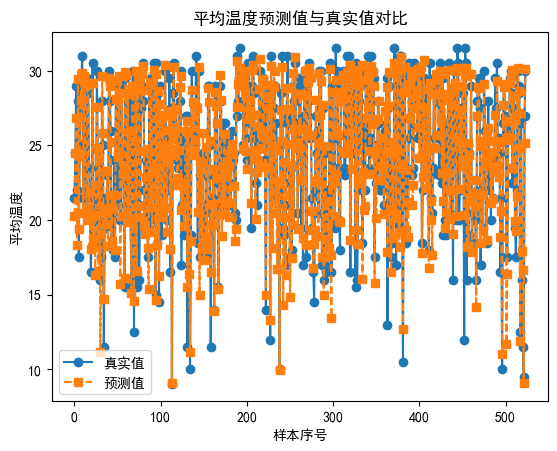

In [6]:
# 绘制折线图展示预测值与真实值对比
# 生成索引用于横坐标（这里简单使用测试集的索引，可根据实际需求调整更合理的横坐标表示方式）
index = range(len(y_test))
plt.plot(index, y_test, label='真实值', marker='o')
plt.plot(index, y_pred, label='预测值', marker='s', linestyle='--')
plt.xlabel('样本序号')
plt.ylabel('平均温度')
plt.title('平均温度预测值与真实值对比')
plt.legend()
plt.show()

In [7]:
print("前5个平均温度真实值：", y_test[:5])
print("前5个平均温度预测值：", y_pred[:5])

前5个平均温度真实值： 29     21.5
254    24.5
415    29.0
589    22.0
778    28.0
Name: 平均温度, dtype: float64
前5个平均温度预测值： [20.295061 24.478325 26.822731 18.302189 29.473213]


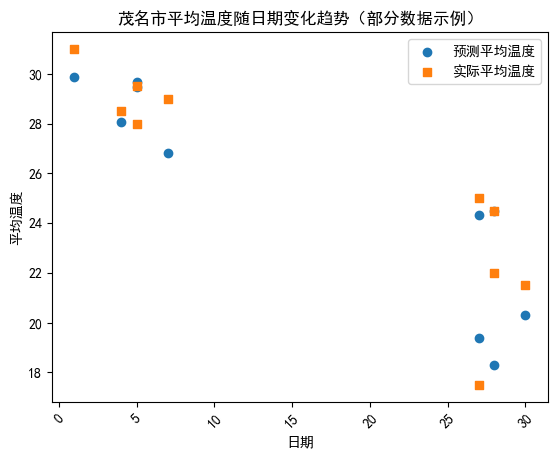

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# 设置中文字体显示及负号显示正常（适用于中文标注及可视化）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


#随机10天的预测点
y_pred = y_pred[:10]
y_test = y_test[:10]
X_test_date = X_test["日"][:10]

# 绘制散点图（点状图），使用plt.scatter替换原来的plt.plot
plt.scatter(X_test_date, y_pred, label='预测平均温度', marker='o')
plt.scatter(X_test_date, y_test, label='实际平均温度', marker='s')
plt.xlabel('日期')
plt.ylabel('平均温度')
plt.title('茂名市平均温度随日期变化趋势（部分数据示例）')
plt.xticks(rotation=45)  # 让x轴刻度标签旋转45度，避免重叠显示不清
plt.legend()
plt.show()

